In [69]:
#######################################################
### Kopia av 2_🏫_Learn.py
### I ett första steg inför travdata
#######################################################

In [70]:

from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

sys.path.append('C:\\Users\\peter\\Documents\\MyProjects\\PyProj\\Trav\\spel\\')

import typ_copy as tp
import travdata as td
import V75_scraping as vs
import concurrent.futures
from IPython.display import display
import pickle
# import streamlit as st
from logging import PlaceHolder
from category_encoders import TargetEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, mean_absolute_error
# import streamlit as st
import sys
import time
import datetime
import json
import pandas as pd
import numpy as np

pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 260)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 120)


# sys.path.append('C:\\Users\\peter\\Documents\\MyProjects\\PyProj\\Trav\\spel\\modeller\\')


pref =  '../'


streamlit grejer

In [71]:

############## streamlit grejer #############################################
# st.set_page_config(page_title="V75 Learning", page_icon="🏫")
# st.markdown("# 🏫 V75 Learning")
print('st.sidebar.header("🏫 V75 Learning")')
#############################################################################


st.sidebar.header("🏫 V75 Learning")


In [72]:

#%%
# -------------- skapa test-modeller
    #               name,   #häst     proba,    kelly,  #motst,  motst_diff, #fav, only_cl, streck, test,  pref
test1 = tp.Typ('test1',  True,    True,     False,       0,   False,      0,   False,    True,  True, pref=pref)
test2 = tp.Typ('test2',  True,    True,     False,       0,   False,      0,   False,    False, True, pref=pref)
test3 = tp.Typ('test3',  True,    True,     False,       0,   False,      0,   False,    False, True, pref=pref)
test4 = tp.Typ('test4',  True,    True,     False,       0,   False,      0,   False,    True,  False, pref=pref)

modeller = [test1, test2, test3, test4]


streck: True i init
Gör denna till produktion
streck: False i init
Gör denna till produktion
streck: False i init
Gör denna till produktion
streck: True i init
Gör denna till produktion


In [73]:

#%%
################################################
#              Web scraping                    #
################################################

def v75_scraping():
    df = vs.v75_scraping(history=True, resultat=True, headless=True)

    for f in ['häst', 'bana', 'kusk', 'h1_kusk', 'h2_kusk', 'h3_kusk', 'h4_kusk', 'h5_kusk', 'h1_bana', 'h2_bana', 'h3_bana', 'h4_bana', 'h5_bana']:
        df[f] = df[f].str.lower()
    return df

def remove_features(df_, remove_mer=[]):
    df = df_.copy()
    df.drop(['startnr', 'vodds', 'podds', 'bins', 'h1_dat',
            'h2_dat', 'h3_dat', 'h4_dat', 'h5_dat'], axis=1, inplace=True)
    
    if remove_mer:
        df.drop(remove_mer, axis=1, inplace=True)

    return df

In [74]:

#%%
################################################
#              Web scraping                    #
################################################

def v75_scraping():
    df = vs.v75_scraping(history=True, resultat=True, headless=True)

    for f in ['häst', 'bana', 'kusk', 'h1_kusk', 'h2_kusk', 'h3_kusk', 'h4_kusk', 'h5_kusk', 'h1_bana', 'h2_bana', 'h3_bana', 'h4_bana', 'h5_bana']:
        df[f] = df[f].str.lower()
    return df

def remove_features(df_, remove_mer=[]):
    df = df_.copy()
    df.drop(['startnr', 'vodds', 'podds', 'bins', 'h1_dat',
            'h2_dat', 'h3_dat', 'h4_dat', 'h5_dat'], axis=1, inplace=True)
    
    if remove_mer:
        df.drop(remove_mer, axis=1, inplace=True)

    return df

###############################################
#              LEARNING                       #
###############################################

def förbered_old(df, meta_fraction=None):
    # Följande datum saknar avd==5 och kan inte användas
    saknas = ['2015-08-15', '2016-08-13', '2017-08-12']
    df = df[~df.datum.isin(saknas)]
    X = df.copy()
    X.drop('plac', axis=1, inplace=True)

    # läs in FEATURES.txt
    with open(pref+'FEATURES.txt', 'r', encoding='utf-8') as f:
        features = f.read().splitlines()

    X = X[features]

    assert len(features) == len(
        X.columns), f'features {len(features)} and X.columns {len(X.columns)} are not the same length'
    assert set(features) == set(
        X.columns), f'features {set(features)} and X.columns {set(X.columns)} are not the same'

    y = (df.plac == 1)*1   # plac 1 eller 0

    for f in ['häst', 'bana', 'kusk', 'h1_kusk', 'h2_kusk', 'h3_kusk', 'h4_kusk', 'h5_kusk', 'h1_bana', 'h2_bana', 'h3_bana', 'h4_bana', 'h5_bana']:
        X[f] = X[f].str.lower()

    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    if meta_fraction == 0:
        # no meta data
        return X, y, None, None

    # use a fraction for meta data
    meta_antal = int(len(X.datum.unique())*meta_fraction)
    meta_datum = X.datum.unique()[-meta_antal:]

    X_val = X.loc[X.datum.isin(meta_datum)]
    y_val = y[X_val.index]
    X = X.loc[~X.datum.isin(meta_datum)]
    y = y.loc[X.index]
    return X, y, X_val, y_val


def concat_data_old(df_all, df_ny, save=True):
    df_ny = df_ny[df_all.columns]
    df_all = pd.concat([df_all, df_ny])
    # remove duplicates
    all_shape = df_all.shape

    df_all = df_all.drop_duplicates(subset=['datum', 'avd', 'häst'])
    assert df_all.shape[0] + \
        90 > all_shape[0], f'{df_all.shape[0]+90} should be more than {all_shape[0]}'
    assert df_all.shape[1] == all_shape[1], f'{df_all.shape[1]} should be {all_shape[1]}'
    if save == True:
        df_all.to_csv(pref+'all_data.csv', index=False)
    return df_all


In [75]:

##### RidgeClassifier (meta model) #####
def learn_meta_ridge_model(X, y, save=True):

    with open(pref+'optimera/params_meta_ridge.json', 'r') as f:
        params = json.load(f)['params']
        # st.write(params)

    ridge_model = RidgeClassifier(**params, random_state=2022)

    ridge_model.fit(X, y)

    if save:
        with open(pref+'modeller/meta_ridge.model', 'wb') as f:
            pickle.dump(ridge_model, f)

    return ridge_model

##### RandomForestClassifier (meta model) #####


def learn_meta_rf_model(X, y, save=True):

    with open(pref+'optimera/params_meta_rf.json', 'r') as f:
        params = json.load(f)
        params = params['params']
        # st.write(params)

    rf_model = RandomForestClassifier(**params, n_jobs=6, random_state=2022)
    rf_model.fit(X, y)

    ######################### for testing ###############################
    rf_train = X.copy(deep=True)
    rf_train['y'] = y
    rf_train.to_csv(pref+'rf_train.csv', index=False)
    #########################              ###############################

    if save:
        with open(pref+'modeller/meta_rf.model', 'wb') as f:
            pickle.dump(rf_model, f)

    return rf_model


##### KNeighborsClassifier (meta model) #####
def learn_meta_knn_model(X, y, save=True):
    with open(pref+'optimera/params_meta_knn.json', 'r') as f:
        params = json.load(f)
        params = params['params']
        # st.write(params)

    knn_model = KNeighborsClassifier(**params, n_jobs=6)
    knn_model.fit(X, y)

    if save:
        with open(pref+'modeller/meta_knn.model', 'wb') as f:
            pickle.dump(knn_model, f)

    return knn_model

def learn_meta_et_model(X, y, save=True):
    with open(pref+'optimera/params_meta_et.json', 'r') as f:
        params = json.load(f)
        params = params['params']

    params = {'n_estimators':10, 'max_depth':None, 'min_samples_leaf':5}
    et_model = ExtraTreesClassifier(**params, n_jobs=6, random_state=2022)
    et_model.fit(X, y)

    if save:
        with open(pref+'modeller/meta_et.model', 'wb') as f:
            pickle.dump(et_model, f)

    return et_model

def prepare_stack_data(stack_data_):
    """Hantera missing values, NaN, etc för meta-modellerna"""

    assert 'y' in stack_data_.columns, 'y is missing in stack_data'
    stack_data = stack_data_.copy()
    stack_data.y = stack_data.y.astype(int)

    """ rensa bort features som inte ska användas """
    # stack_data.drop(['startnr', 'vodds', 'podds', 'bins', 'h1_dat',
    #             'h2_dat', 'h3_dat', 'h4_dat', 'h5_dat'], axis=1, inplace=True)

    """ Fyll i saknade numeriska värden med 0 """
    numericals = stack_data.drop('y', axis=1).select_dtypes(exclude=['object']).columns
    stack_data[numericals] = stack_data[numericals].fillna(0)

    """ Fyll i saknade kategoriska värden med 'missing' """
    categoricals = stack_data.drop('y',axis=1).select_dtypes(include=['object']).columns
    stack_data[categoricals] = stack_data[categoricals].fillna('missing')

    # """ Hantera high cardinality """
    # cardinality_list=['häst','kusk','h1_kusk','h2_kusk','h3_kusk','h4_kusk','h5_kusk']

    """ Target encoding"""
    target_encode_list = ['bana', 'häst', 'kusk', 'kön', 'h1_kusk', 'h1_bana', 'h2_kusk', 'h2_bana',
                          'h3_kusk', 'h3_bana', 'h4_kusk', 'h4_bana', 'h5_kusk', 'h5_bana']

    y = stack_data['y']
    enc = TargetEncoder(cols=target_encode_list, min_samples_leaf=20, smoothing=10).fit(stack_data, y)
    stack_data = enc.transform(stack_data)

    return stack_data, enc

def learn_meta_models(stack_data, meta_features, save=True):
    """ all meta models will be fitted on X and y """  
    
    stack_data, ENC = prepare_stack_data(stack_data)
    stack_data.to_csv(pref+'prepared_stack_data.csv', index=False)   # for testing purposes
    print(meta_features)
    Ridge_Classifier = learn_meta_ridge_model(stack_data[meta_features], stack_data.y, save=save)
    RandomForest_Classifier = learn_meta_rf_model(stack_data[meta_features], stack_data.y, save=save)
    Knn_model = learn_meta_knn_model(stack_data[meta_features], stack_data.y, save=save)
    ExtraTrees_Classifier = learn_meta_et_model(stack_data[meta_features], stack_data.y, save=save)

    return Ridge_Classifier, RandomForest_Classifier, Knn_model, ExtraTrees_Classifier, ENC


Nytt ###

In [76]:
def skapa_data_för_datum(df_, curr_datum_ix, frac=0.5):
    df = df_.copy()
    datumar = df.datum.unique()
    curr_datum = datumar[curr_datum_ix]
    base_datum_ix = int(len(datumar[:curr_datum_ix]) * frac)  # base models

    base_datum = datumar[base_datum_ix]
    X_train = df.query(f'datum < @base_datum')
    y_train = X_train.y
    X_train = X_train.drop('y', axis=1)

    X_meta = df.query(f'datum >= @base_datum and datum < @curr_datum')
    y_meta = X_meta.y
    X_meta = X_meta.drop('y', axis=1)

    X_curr = df.query(f'datum == @curr_datum')
    y_curr = X_curr.y
    X_curr = X_curr.drop(['y'], axis=1)

    return X_train, y_train, X_meta, y_meta, X_curr, y_curr



def skapa_stack_data(model, name, X_meta, stack_data):
    """Skapa stack_data"""
    assert 'y' in stack_data.columns, 'y is missing in stack_data'
    this_proba = model.predict(X_meta)
    # print(f'X_meta.shape = {X_meta.shape} this_proba.shape={this_proba.shape}')

    # Bygg up meta-kolumnerna (proba) för denns modell
    nr = name[3:]
    stack_data['proba'+nr] = this_proba
    return stack_data



In [77]:
def hold_out_val_data(df_work, val_fraction):
    y=df_work.y
    X=df_work.drop('y', axis=1)
    if val_fraction == 0:
        # no validation data
        X_val, y_val = None, None
    else:    
        # use a fraction for meta data
        datumar=df_work.datum.unique()
        val_antal = int(len(datumar)*val_fraction)
        val_datum = datumar[-val_antal:]

        X_val = X.loc[X.datum.isin(val_datum)]
        y_val = y[X_val.index]
        X = X.loc[~X.datum.isin(val_datum)]
        y = y.loc[X.index]
    return X, y, X_val, y_val 

In [78]:
def learn_modeller(modeller, X_train, y_train, X_meta, y_meta):
    ############################################################################################################
    #                        Här görs en första learn av modeller och sedan skapas stack_data
    #                        - Learn modeller på X,y
    #                        - Ha en egen skapa_stack_funktion (som också används längre ner)
    #                           - Skapa stack_data med predict X_meta med nya modellerna
    #                           - Spara även X_meta, y_meta i stack_data
    ############################################################################################################
    stack_data = X_meta.copy()
    stack_data['y'] = y_meta
    assert 'y' in stack_data.columns, '1. y is missing in stack_data'
    for model in modeller:
        name = model.name
        print(f'first Learn {name} {X_train.datum.min()} -{X_train.datum.max()}')

        model.learn(X_train, y_train, params=None, save=True)

        stack_data = skapa_stack_data(model, name, X_meta, stack_data)

    assert 'y' in stack_data.columns, '3. y is missing in stack_data'
    # stack_data, enc = prepare_stack_data(stack_data)

    return stack_data

def normal_learning(modeller, meta_modeller, X_train, y_train, X_meta, y_meta):
    stack_data = learn_modeller(modeller, X_train, y_train, X_meta, y_meta)
    assert 'y' in stack_data.columns, 'y is missing in stack_data'
    stack_data.to_csv('first_stack_data.csv', index=False)

    # """ Learn meta_modeller på stack_data """
    meta_features = stack_data.drop(['datum', 'avd','y'],axis=1).columns.to_list()
    _, _, _, _, enc = learn_meta_models(stack_data, meta_features)
    
    return stack_data[meta_features + ['y']]
    


TimeSeriesLearning

In [79]:
# TimeSeriesSplit learning models
def TimeSeries_learning(df_ny_, modeller, n_splits=5, val_fraction=0.25, save=True, learn_models=True):
    """
    Skapar en stack med {1 - meta_fraction} av X från alla modeller. Används som input till meta_model.
        - learn_models=True betyder att vi både gör en learning och skapar en stack
        - learn_models=False betyder att vi bara skapar en stack och då har param save ingen funktion
    """
    
    # Skapa v75-instans
    v75 = td.v75(pref=pref)
    
    base_features = v75.get_df().columns.to_list()
    
    if df_ny_ is not None:  # Har vi en ny omgång?
        df_ny = df_ny_[base_features].copy()
        v75.concat(df_ny, update_work=True, save=True)

    # Hämta data från v75
    _ = v75.förbered_data(missing_num=False)  # num hanteras av catboost
    df_work = v75.test_lägg_till_kolumner()
    
    # base_ix = 100  # antal omgångar som vi startar bas-modellerna från i backtesting

    # datumar = df_work.datum.unique()
    # startdatum = datumar[base_ix]

    # assert val_fraction==0, 'meta_fraction måste vara 0 tills vidare'
    X, y, X_val, y_val = hold_out_val_data(df_work, val_fraction)
    
    validation_text = ""

    if X_val is not None:
        validation_text = f', Validation: {X_val.datum.iloc[0]} - {X_val.datum.iloc[-1]}'

    # st.info(f'Train: {X.datum.iloc[0]} - {X.datum.iloc[-1]} {validation_text}')
    print(f"Train: {X.datum.iloc[0]} - {X.datum.iloc[-1]} {validation_text}")

    ts = TimeSeriesSplit(n_splits=n_splits)
    
    stacked_data = pd.DataFrame()

    ###############################################################################
    #         Step 1: Learn the models on ts.split X_train and predict on X_test  #
    ###############################################################################
    # st.write('Skapar stacked_data till meta')
    # my_bar = st.progress(0)

    step = 1/(n_splits*len(modeller))-0.0000001
    steps = 0.0

    for enum, (train_index, test_index) in enumerate(ts.split(X, y)):
        print('shape of X', X.shape, 'shape of X_train', X.iloc[train_index].shape, 'shape of X_test', X.iloc[test_index].shape)
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        temp_stack = X_test.copy()
        temp_stack['y'] = y_test
        for model in modeller:
            steps += step
            # progress bar continues to complete from 0 to 100
            
            # my_bar.progress(steps)

            if learn_models:
                with open(pref+'optimera/params_'+model.name+'.json', 'r') as f:
                    params = json.load(f)
                    params = params['params']
                # learn på X_train-delen
                
                cbc = model.learn(X_train, y_train, X_test,
                                y_test, params=params, save=save)

            # predict the new fitted model on X_test-delen
            nr = model.name[3:]
            this_proba = model.predict(X_test)

            # Bygg up meta-kolumnen proba för denns modell
            temp_stack['proba'+nr] = this_proba

        if stacked_data.empty:
            stacked_data = temp_stack.copy()
        else:        
            stacked_data = pd.concat([stacked_data, temp_stack], ignore_index=True)
        stacked_data.y = stacked_data.y.astype(int)

    
    # stacked_data_y = stacked_data.pop('y')
    meta_features = stacked_data.drop(['datum', 'avd', 'y'], axis=1).columns.to_list()

    # my_bar.progress(1.0)

    ###############################################################################
    #         Step 2:       Learn the meta models                                 #
    ###############################################################################
    # st.write('Learning meta models')
    print('Learning meta models')
    _, _, _, _, enc = learn_meta_models(stacked_data, meta_features)

    ###############################################################################
    #         Step 3: learn models on all of X - what iteration to use?           #
    ###############################################################################
    # st.write('Learn models on all of Train')
    print('Learn models on all of Train')
    
    # my_bar2 = st.progress(0)
    ant_meta_models = 4
    step = 1/(ant_meta_models) - 0.0000001
    steps = 0.0
    # my_bar2.progress(steps)

    for model in modeller:
        steps += step
        # my_bar2.progress(steps)
        if learn_models:
            with open(pref+'optimera/params_'+model.name+'.json', 'r') as f:
                params = json.load(f)

            params = params['params']
            cbc = model.learn(X, y, None, None, 
                              iterations=500, 
                              params=params, 
                              save=save)

    # my_bar2.progress(1.0)
    # st.empty()
    
    return stacked_data[meta_features + ['y']]


def skapa_stack_learning(X_, y,meta_features):
    # För validate
    X = X_.copy()
    print(X.shape)
    print(len(meta_features))
    stacked_data = X[meta_features].copy()
    for model in modeller:
        part = model.name[3:]
        stacked_data['proba'+part] = model.predict(X)
        meta_features += ['proba'+part]

    assert list(stacked_data.columns) == meta_features, f'columns in stacked_data is wrong {list(stacked_data.columns)} \n {meta_features}'
    assert len(stacked_data) == len(y), f'stacked_data {len(stacked_data)} and y {len(y)} should have same length'
    return stacked_data[meta_features], meta_features, y  


In [80]:

#%%
##############################################################
#                     VALIDATE                               #
##############################################################

def predict_meta_ridge_model(X, ridge_model=None):
    if ridge_model is None:
        with open(pref+'modeller/meta_ridge.model', 'rb') as f:
            ridge_model = pickle.load(f)

    return ridge_model._predict_proba_lr(X)


def predict_meta_rf_model(X, rf_model=None):
    if rf_model is None:
        with open(pref+'modeller/meta_rf.model', 'rb') as f:
            rf_model = pickle.load(f)

    return rf_model.predict_proba(X)


def predict_meta_et_model(X, et_model=None):
    if et_model is None:
        with open(pref+'modeller/meta_et.model', 'rb') as f:
            et_model = pickle.load(f)

    return et_model.predict_proba(X)

def predict_meta_knn_model(X, knn_model=None):
    if knn_model is None:
        with open(pref+'modeller/meta_knn.model', 'rb') as f:
            knn_model = pickle.load(f)

    return knn_model.predict_proba(X)

def predict_meta_mean(preds, type):   # type='geometric' or 'arithmetic'
    if type=='arithmetic':
        return (preds.rf + preds.et + preds.ridge + preds.knn)/4
    
    return (preds.rf * preds.et * preds.ridge * preds.knn)**(1/4)

def predict_meta_models(stack_data, meta_features):
    preds = pd.DataFrame(columns=['rf', 'ridge', 'knn', 'meta'])
    stack_data, ENC = prepare_stack_data(stack_data)
    preds['rf'] = predict_meta_rf_model(stack_data[meta_features])[:, 1]
    preds['ridge'] = predict_meta_ridge_model(stack_data[meta_features])[:, 1]
    preds['knn'] = predict_meta_knn_model(stack_data[meta_features])[:, 1]
    preds['et']  = predict_meta_et_model(stack_data[meta_features])[:, 1]
    preds['meta'] = predict_meta_mean(preds, type='geometric')
    
    return preds
    

# write the scores


def display_scores(y_true, y_pred, spelade):
    # st.write('AUC', round(roc_auc_score(y_true, y_pred), 5), 'F1', round(f1_score(y_true, y_pred), 5), 'Acc', round(
    #     accuracy_score(y_true, y_pred), 5), 'MAE', round(mean_absolute_error(y_true, y_pred), 5), '\n', spelade)
    print('AUC', round(roc_auc_score(y_true, y_pred), 5), 'F1', round(f1_score(y_true, y_pred), 5), 'Acc', round(
        accuracy_score(y_true, y_pred), 5), 'MAE', round(mean_absolute_error(y_true, y_pred), 5), '\n', spelade)
    return roc_auc_score(y_true, y_pred)


def find_threshold(y_pred, fr, to, margin):
    """ hitta threshold som ger 2.5 spelade per avdelning """
    thresh = 0
    cnt = 0
    # make a binary search
    while cnt < 1000:
        thresh = (fr + to) / 2
        antal_spelade_per_avd = 12 * sum(y_pred > thresh)/len(y_pred)
        if (antal_spelade_per_avd > (2.5 - margin)) and (antal_spelade_per_avd < (2.5 + margin)):
            break

        if antal_spelade_per_avd > 2.5:
            fr = thresh-0.00001
        else:
            to = thresh+0.00001
        cnt += 1

    # print('ant', cnt, 'thresh', round(thresh, 4))
    if cnt >= 1000:
        print('threshold not found', 'fr', round(fr, 6), 'to', round(to, 6))

    return thresh


def plot_confusion_matrix(y_true, y_pred, model, fr=0.0, to=0.9, margin=0.001):

    #### Först:  hitta ett threshold som tippar ca 2.5 hästar per avd ####
    # thresh = 0
    # for thresh in np.arange(fr, to, step):
    #     cost = 12*sum(y_pred > thresh)/len(y_pred)
    #     if cost < 2.5:
    #         break
    thresh = round(find_threshold(y_pred, fr, to, margin), 4)
    print(f'Threshold: {thresh}\n')
    y_pred = (y_pred > thresh).astype(int)
    # confusion_matrix_graph(y_true, y_pred, f'{model} threshold={thresh}')

    #### Sedan: confusion matrix graph ####
    title = f'{model} threshold={thresh}'
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred,)
    fig, ax = plt.subplots()
    sns.set(font_scale=2.0)
    sns.heatmap(cm/np.sum(cm), annot=True, fmt=".2%", linewidths=.5,
                square=True, cmap='Blues_r')

    # increase font size
    plt.rcParams['font.size'] = 20
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    
    plt.show()
    # st.write(fig)

    # read dict from disk
    try:
        with open(pref+'modeller/meta_scores.pkl', 'rb') as f:
            meta_scores = pickle.load(f)
    except:
        # st.write('No meta_scores.pkl found')
        print('No meta_scores.pkl found')
        meta_scores = {'knn': 0, 'rf': 0, 'ridge': 0, 'et': 0}

    #### print scores ####
    typ_AUC = display_scores(
        y_true, y_pred, f'spelade per lopp: {round(12 * sum(y_pred)/len(y_pred),4)}')
    meta_scores[model] = float(typ_AUC)
    #### save dict to disk ####
    with open(pref+'modeller/meta_scores.pkl', 'wb') as f:
        pickle.dump(meta_scores, f)


validate

In [81]:


def validate(drop=[], fraction=None):
    # Skapa v75-instans
    v75 = td.v75(pref=pref)

    base_features = v75.get_df().columns.to_list()

    # Hämta data från v75
    _ = v75.förbered_data(missing_num=False)  # num hanteras av catboost
    df_work = v75.test_lägg_till_kolumner()

    # st.info('skall endast  köras efter "Learn for Validation"')
    # df_all = pd.read_csv(pref+'all_data.csv')

    
    _, _, X_val, y_val = hold_out_val_data(df_work, fraction)
    # st.info(f'Validerar på:  {X_val.datum.iloc[0]} - -{X_val.datum.iloc[-1]}')
    print(f'Validerar på:  {X_val.datum.iloc[0]} - -{X_val.datum.iloc[-1]}')

    # # create the stack from validation data
    # meta_features = all columns except avd and datum
    meta_features = [col for col in df_work.columns if col not in ['datum','avd', 'y']]

    stacked_val, meta_features, y_val = skapa_stack_learning(X_val, y_val, meta_features)

    stacked_val = stacked_val.drop(drop, axis=1)

    # ##############################################################
    # #                          Meta models                       #
    # ##############################################################

    stacked_val['y'] = y_val
    y_true = y_val.values

    y_preds = predict_meta_models(stacked_val, meta_features)

    # ############## write y_true to file for testing ##############
    # # first make y_true a dataframe
    # rf_y_true = pd.DataFrame(y_true, columns=['y'])
    # rf_y_true.to_csv(pref+'rf_y_true.csv', index=False)
    # ##############################################################

    print("st.info('förbereder meta plot')")
    plot_confusion_matrix(y_true, y_preds.meta, 'meta', fr=0.0, to=0.9)

    # st.write('\n')
    print("st.info('förbereder rf plot')")
    plot_confusion_matrix(y_true, y_preds.rf, 'rf',
                        fr=0.0, to=1.0, margin=0.01)

    # st.write('\n')
    print("st.info('förbereder et plot')")
    plot_confusion_matrix(y_true, y_preds.et, 'et',
                      fr=0.0, to=1.0, margin=0.01)

    # st.write('\n')
    print("st.info('förbereder knn plot')")
    plot_confusion_matrix(y_true, y_preds.knn, 'knn', fr=0.0, to=0.9)

    # st.write('\n')
    print("st.info('förbereder ridge plot')")
    plot_confusion_matrix(y_true, y_preds.ridge, 'ridge', fr=0.0, to=0.9)
    # # placeholder.empty()

    # st.write('\n')
    # st.info('förbereder lasso plot')
    # plot_confusion_matrix(y_true, predict_meta_model(stacked_val, meta_model='lasso'),
    #                       'lasso', fr=0.0, to=0.9)
    # # placeholder.empty()

    # stacked_val['y'] = y_true
    # stacked_val['avd'] = X_val.avd.values

    # ################################################################
    # #                         proba 6, 1, 9, (16)                  #
    # ################################################################
    # st.write('\n')
    # for model in typer:
    #     st.write('\n')
    #     name = 'proba' + model.name[3:]
    #     y_pred = stacked_val[name]
    #     plot_confusion_matrix(y_true, y_pred, name, fr=0.0, to=0.9)

#%%
##############################################################
#            FINAL LEARNING                                  #
##############################################################

def final_learning(modeller, n_splits=5):
    # st.info('Final learning on all the data')
    print('Final learning on all the data')
    _ = TimeSeries_learning( None, modeller, n_splits=n_splits, meta_fraction=0, save=True)

    # st.info('Step 2: Final learn meta model')
    # _, _, _, _, enc = learn_meta_models(stacked_data, meta_featues)

    # st.success('✔️ Final learning done')
    print('Final learning done')

#%%
def scrape(full=True):
    # scraping.write('Starta web-scraping för ny data')
    # with st.spinner('Ta det lugnt!'):
        # st.image('winning_horse.png')  # ,use_column_width=True)
        #####################
        # start v75_scraping as a thread
        #####################
        i = 0.0
        # placeholder = st.empty()
        seconds = 0
        # my_bar = st.progress(i)
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future = executor.submit(v75_scraping)
            while future.running():
                time.sleep(1)
                seconds += 1
                # placeholder.write(f"⏳ {seconds} sekunder")
                i += 1/65
                if i < 0.99:
                    pass
                    # my_bar.progress(i)
            # my_bar.progress(1.0)
            # scraping.write('✔️ Scraping done, pls wait')
            print('✔️ Scraping done, pls wait')
            time.sleep(2)
            df = future.result()
            # scraping.write(f'✔️ {len(df)} rader hämtade')
            print(f'✔️ {len(df)} rader hämtade')
            
            df.to_csv('sparad_scrape_learn.csv', index=False)

        # st.balloons()
        # my_bar.empty()
        # placeholder.empty()

        # st.session_state.df = df


# models = [typ6, typ1, typ9]

#%%
# top = st.container()
# buttons = st.container()
# scraping = st.container()

############################################
#   Init session_state                     #
############################################
# with top:
#     if 'fraction' not in st.session_state:
#         st.session_state['fraction'] = 0.25
fraction = 0.25
#     if 'df' not in st.session_state:
#         st.session_state['df'] = None
omg_df = pd.read_csv(pref+'omg_att_spela_link.csv')
urlen = omg_df.Link.values[0]
datum = urlen.split('spel/')[1][0:10]
#     if 'datum' not in st.session_state:
#         omg_df = pd.read_csv('omg_att_spela_link.csv')
#         urlen = omg_df.Link.values[0]
#         datum = urlen.split('spel/')[1][0:10]
#         st.session_state.datum = datum

#     if 'datum' in st.session_state:
#         datum = st.session_state['datum']
#         year = int(datum[:4])
#         month = int(datum[5:7])
#         day = int(datum[8:])
#         datum = st.sidebar.date_input(
#             'Välj datum', datetime.date(year, month, day))
#         datum = datum.strftime('%Y-%m-%d')

        # if datum != st.session_state['datum']:
        #     st.session_state['datum'] = datum
        #     datum = "https://www.atg.se/spel/"+datum+"/V75/"
        #     omg_df = pd.DataFrame([datum], columns=['Link'])
        #     omg_df.to_csv('omg_att_spela_link.csv', index=False)

    # st.header(f'Omgång:  {st.session_state.datum}')

###########################################
# control flow with buttons               #
###########################################
# with buttons:
#     if st.sidebar.button('scrape'):
#         st.write(f'web scraping {st.session_state.datum}')
#         try:
#             scrape()
#             del st.session_state.datum  # säkra att datum är samma som i scraping
#         except:
#             st.error(
#                 "Fel i web scraping. Kolla att resultat finns för datum och internet är tillgängligt")

#     if st.sidebar.button('reuse scrape'):
#         # del st.session_state.datum  # säkra att datum är samma som i scraping
#         try:
#             df = pd.read_csv('sparad_scrape_learn.csv')
#             st.session_state.df = df
#             if df.datum.iloc[0] != st.session_state.datum:
#                 st.error(
#                     f'Datum i data = {df.datum.iloc[0]} \n\n är inte samma som i omgång')
#             else:
#                 st.success(f'inläst data med datum = {df.datum.iloc[0]}')
#         except:
#             # write error message
#             st.error('Ingen data sparad')

#     if st.session_state.df is not None:
#         if st.sidebar.button('Learn for validation'):
#             st.write('TimeSeries learning for validation')
#             fraction = st.session_state.fraction
#             df = st.session_state.df
#             st.write(
#                 f'learn models and meta models on first {(1-fraction)*100} % of the data')

#             stacked_data = TimeSeries_learning(
#                 df, yper, n_splits=5, meta_fraction=fraction, save=True, learn_models=True)
#             st.success('✔️ TimeSeries learning done')

#         if st.sidebar.button('Validate'):
#             validate(fraction=st.session_state.fraction)

#         if st.sidebar.button('Final learning'):
#             final_learning(yper)

#         if st.sidebar.button('Clear'):
#             st.empty()




För Testerna

Validation
../all_data.csv
Loading dataframe from the file: ../all_data.csv
Validerar på:  2020-07-02 - -2022-10-01
(11747, 77)
75
Loading model: test1
Loading model: test2
drop streck
Loading model: test3
drop streck
Loading model: test4
st.info('förbereder meta plot')
ant 13 thresh 0.1245
Threshold: 0.1245



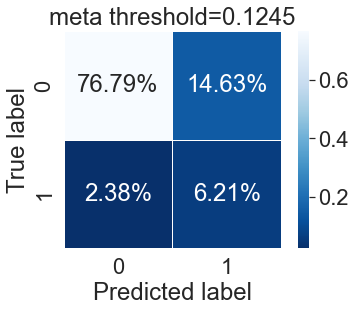

AUC 0.78175 F1 0.42233 Acc 0.83 MAE 0.17 
 spelade per lopp: 2.5007
st.info('förbereder rf plot')
ant 9 thresh 0.1045
Threshold: 0.1045



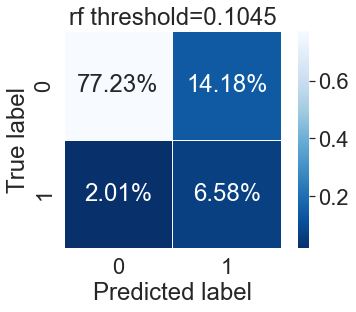

AUC 0.80548 F1 0.44838 Acc 0.83809 MAE 0.16191 
 spelade per lopp: 2.4915
st.info('förbereder et plot')
ant 9 thresh 0.1065
Threshold: 0.1065



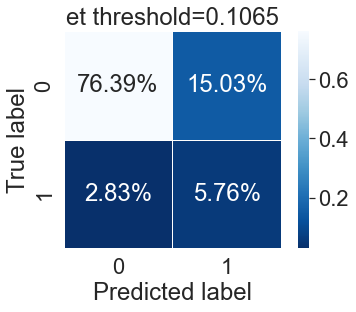

AUC 0.7533 F1 0.39235 Acc 0.82149 MAE 0.17851 
 spelade per lopp: 2.4946
st.info('förbereder knn plot')
ant 16 thresh 0.0864
Threshold: 0.0864



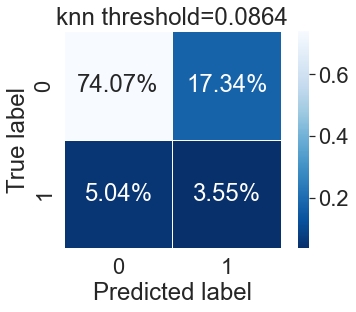

AUC 0.61179 F1 0.24083 Acc 0.7762 MAE 0.2238 
 spelade per lopp: 2.5069
st.info('förbereder ridge plot')
ant 14 thresh 0.318
Threshold: 0.318



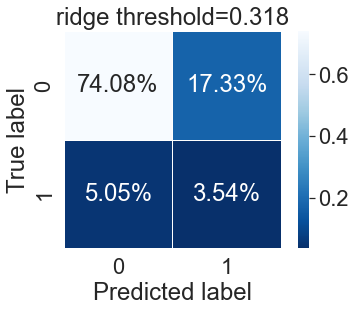

AUC 0.61134 F1 0.24039 Acc 0.7762 MAE 0.2238 
 spelade per lopp: 2.5048


In [82]:

button = 'validate'   # 'scrape'  # 'reuse'  # 'learn'  # 'validate'  # 'final'  # 'clear'


if button == 'scrape':
    print(f'web scraping {datum}')
    try:
        scrape()
        # del st.session_state.datum  # säkra att datum är samma som i scraping
    except:
        print("Fel i web scraping. Kolla att resultat finns för datum och internet är tillgängligt")
else: # resuse scrape
    try:
        df_ny = pd.read_csv(pref+'sparad_scrape_learn.csv')
        # st.session_state.df = df
    except:
        # write error message
        print('Ingen data sparad')
        
if button=='learn':
    print('TimeSeries learning for validation')
    try:
        df_ny = pd.read_csv(pref+'sparad_scrape_learn.csv')
        loaded=True
        # st.session_state.df = df
    except:
        loaded=False
        # write error message
        print('Ingen data sparad')
    if loaded:
        print(f'learn models and meta models on first {(1-fraction)*100} % of the data')

        stacked_data = TimeSeries_learning(df_ny, modeller, n_splits=5, val_fraction=fraction, save=True, learn_models=True)
        display(stacked_data)
        print('✔️ TimeSeries learning done')
        
if button == 'validate':
    print('Validation')

    # validate(fraction=st.session_state.fraction)
    validate(fraction=fraction)

In [83]:

# def make_gridSearch_et(X, y, verbose=False):

#     from sklearn.model_selection import RandomizedSearchCV
#     # Grid Search
#     seed = 2022
#     parameters = {
#         'n_estimators': [100, 200, 500, 1000],
#         'min_samples_leaf': [5, 10, 20],
#         'max_features': [2, 3, 4]

#     }

#     clf = RandomizedSearchCV(ExtraTreesClassifier(), param_distributions=parameters, n_jobs=4, cv=5,
#                              random_state=seed, scoring='roc_auc',
#                              return_train_score=False, refit=True,
#                              verbose=verbose)

#     # fitting the grid search

#     res = clf.fit(X, y)
#     d = {'params': res.best_params_, 'AUC': round(res.best_score_, 5)}
#     print('res.best_estimator_:', res.best_estimator_,
#           'AUC', round(res.best_score_, 5))
#     with open(pref+'optimera/params_meta_et.json', 'w') as f:
#         json.dump(d, f)

# X=pd.read_csv('../prepared_stack_data.csv')
# y=X.pop('y')
# meta_features = X.drop(['datum','avd'], axis=1).columns.to_list()
# print(meta_features, len(meta_features  ))
# make_gridSearch_et(X[meta_features],y, verbose=5)